# <div style='color:white;background: #005792;text-align: center;padding: 15px 0'>Recommandations - Modélisation d'un modèle machine learning avec Annoy</div>

## Participants
* Samantha
* Rachelle
* Andrew

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Configuration des variables globales</a></div>

### Installation des librairies

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install plotly-express
# !pip install plotly

# !pip install scikit-learn
# !pip install annoy

#!pip install shap
#!pip install graphviz

### Importation des librairies

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD, PCA

from scipy.sparse import hstack
from annoy import AnnoyIndex

### Chargement des fichiers

In [1]:
source_dir= '/home/dstrec/dstrec/010_data/002_merged'

file_final = f"{source_dir}/dstrec.csv"

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Préparation des données</a></div>

### Chargement des jeux de données

In [3]:
df = pd.read_csv(file_final)

### Calcul de la note moyenne pondérée (WAR)

In [4]:
C = df['averageRating'].mean()
m = df['numVotes'].quantile(0.90)

def weighted_average_rating(x, m=m, C=C):
    v = x['numVotes']
    R = x['averageRating']
    return (v/(v + m) * R) + (m/(m + v) * C)

df['weightedAverageRating'] = df.apply(weighted_average_rating, axis=1)

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Préparation des caractéristiques basées sur le contenu et les utilisateurs</a></div>

### Encodage one-hot pour les colonnes catégorielles

In [5]:
df = df.drop(['imdbId'], axis=1)

categorical_features = ['director', 'actor_actress', 'producer']
numeric_features = [col for col in df.columns if col not in categorical_features + ['title']]

numeric_transformer = MaxAbsScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    sparse_threshold=0.5)

content_features = preprocessor.fit_transform(df.drop('title', axis=1))

### Normalisation des caractéristiques des films avec MaxAbsScaler

In [6]:
scaler = MaxAbsScaler()
scaled_features = scaler.fit_transform(content_features)

### Réduction de la dimensionnalité avec TruncatedSVD

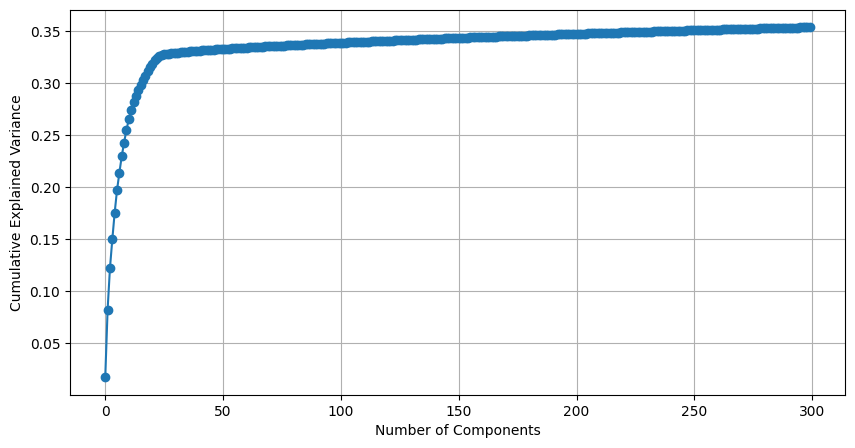

Variance expliquée avec 300 composantes: 0.3540425983746793


In [8]:
# Fixation du nombre de composantes pour SVD
fixed_components = 300

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Plot pour visualiser la variance expliquée
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

print(f"Variance expliquée avec {fixed_components} composantes: {cumulative_variance[fixed_components - 1]}")


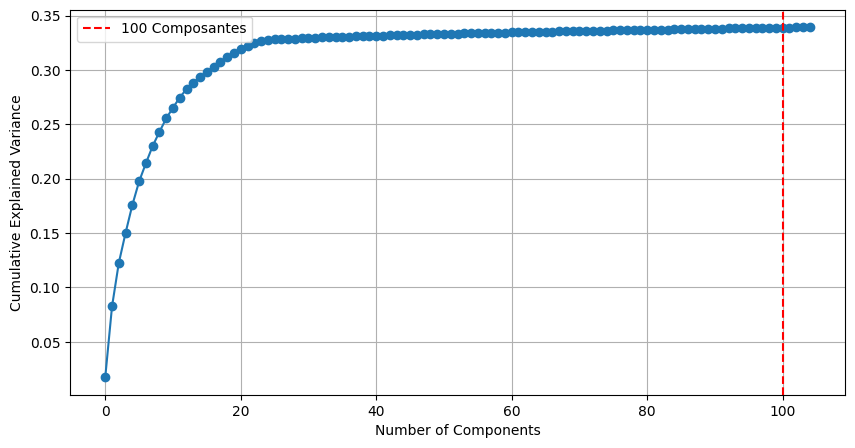

Variance expliquée avec 100 composantes: 0.3392855877206437


In [7]:
# Fixation du nombre de composantes pour SVD
fixed_components = 105

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.axvline(x=100, color='r', linestyle='--', label='100 Composantes')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.show()

print(f"Variance expliquée avec 100 composantes: {cumulative_variance[fixed_components - 1]}")

<b>Choix des Composantes</b><br>
Nous avons observé que la variance expliquée par les composantes supplémentaires commence à stagner après un certain point. Plus précisément, la variance expliquée avec 100 composantes est de 33.88% alors qu'elle n'est que de 35.40% avec 300 composantes. L'augmentation marginale de la variance expliquée ne justifie pas la complexité computationnelle supplémentaire d'utiliser plus de composantes.

<b>Justification du Choix</b><br>
L'objectif est de trouver un équilibre entre la complexité du modèle et la performance. Avec 100 composantes, nous capturons déjà une grande partie de la variance dans les données (33.88%), et la différence avec le maximum atteint par 300 composantes (35.40%) est minime.

In [16]:
# Fixation du nombre de composantes pour SVD
fixed_components = 100

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Variance expliquée cumulée
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Construction de l'Index Annoy</a></div>

### Construction de l'index Annoy

In [49]:
def build_annoy_index(reduced_features, num_trees, metric):
    # Construction de l'index Annoy
    f = reduced_features.shape[1]
    t = AnnoyIndex(f, metric)

    # Ajout des vecteurs à l'index
    for i in range(len(reduced_features)):
        t.add_item(i, reduced_features[i])
    t.build(num_trees)
    return t

### Construction des recommandations

In [50]:
def recommend_movies(t,movie_title, df, num_recommendations=5):
    # Vérifie si le film est dans la base de données
    if movie_title not in df['title'].values:
        return "Ce film n'est pas dans la base de données."
    
    # Récupère l'index du film
    movie_index = df.index[df['title'] == movie_title].tolist()[0]
    
    # Recherche des films les plus similaires
    similar_items, distances = t.get_nns_by_item(movie_index, num_recommendations * 2 + 1, include_distances=True)
    
    # Filtrage des recommandations pour éviter les doublons trop proches
    filtered_indices = []
    filtered_distances = []
    for idx, dist in zip(similar_items, distances):
        if idx != movie_index and len(filtered_indices) < num_recommendations and dist > 1e-6:
            filtered_indices.append(idx)
            filtered_distances.append(dist)
    
    # Transformation logarithmique des distances pour des scores de similarité
    max_distance = max(filtered_distances) if filtered_distances else 1
    similarity_scores = [1 - (np.log1p(d) / np.log1p(max_distance)) for d in filtered_distances]
    
    # Filtrage supplémentaire basé sur des caractéristiques similaires
    genres_target = df.loc[movie_index, 'Action':'Western'].astype(bool)
    filtered_movies = []
    filtered_scores = []
    for idx, score in zip(filtered_indices, similarity_scores):
        genres_recommend = df.loc[idx, 'Action':'Western'].astype(bool)
        if any(genres_target & genres_recommend):  # Filtrage basé sur la similarité des genres
            filtered_movies.append(df['title'].iloc[idx])
            filtered_scores.append(score)
            if len(filtered_movies) >= num_recommendations:
                break
    
    return list(zip(filtered_movies, filtered_scores))

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Comparaison des Configurations</a></div>

### Test des différentes métriques et nombres d'arbres

In [51]:
num_trees_list = [10, 20, 30, 40, 50, 100]
metrics = ['angular', 'euclidean', 'manhattan']
results = {}

for metric in metrics:
    results[metric] = {}
    for num_trees in num_trees_list:
        t = build_annoy_index(reduced_features, num_trees, metric)
        recommendations = recommend_movies(t, 'Star Trek', df, 5)
        results[metric][num_trees] = recommendations

# Comparaison des résultats
for metric in metrics:
    for num_trees in num_trees_list:
        print(f"Metric: {metric}, Number of trees: {num_trees}, Recommendations: {results[metric][num_trees]}")


Metric: angular, Number of trees: 10, Recommendations: [('X-Men: Days of Future Past', 0.7497406812234657), ('Edge of Tomorrow', 0.6655315047482762), ('Rogue One: A Star Wars Story', 0.4785006962119581), ('Star Wars: Episode VII - The Force Awakens', 0.026067559183743594), ('Star Trek Into Darkness', 0.0)]
Metric: angular, Number of trees: 20, Recommendations: [('X-Men: Days of Future Past', 0.7497406812234657), ('Edge of Tomorrow', 0.6655315047482762), ('Rogue One: A Star Wars Story', 0.4785006962119581), ('Star Wars: Episode VII - The Force Awakens', 0.026067559183743594), ('Star Trek Into Darkness', 0.0)]
Metric: angular, Number of trees: 30, Recommendations: [('X-Men: Days of Future Past', 0.7497406812234657), ('Edge of Tomorrow', 0.6655315047482762), ('Rogue One: A Star Wars Story', 0.4785006962119581), ('Star Wars: Episode VII - The Force Awakens', 0.026067559183743594), ('Star Trek Into Darkness', 0.0)]
Metric: angular, Number of trees: 40, Recommendations: [('X-Men: Days of Fut

<b>Analyse et Conclusion</b><br>
Recommandations Consistentes : Les recommandations sont très similaires, voire identiques, pour chaque combinaison de nombre d'arbres dans une métrique donnée. Cela indique que le nombre d'arbres au-delà de 10 n'a pas d'impact significatif sur les recommandations dans ce contexte.

<b>Comparaison des Métriques :</b><br>

* `Angular` : Les scores de similarité sont légèrement plus bas que ceux obtenus avec Euclidean, mais les recommandations sont très similaires.
* `Euclidean` : Les scores de similarité sont légèrement plus élevés que ceux obtenus avec Angular, ce qui pourrait indiquer une meilleure performance pour certaines applications.
* `Manhattan` : Les scores de similarité sont les plus bas parmi les trois métriques testées, ce qui pourrait indiquer une performance légèrement inférieure.


<b>Meilleure Métrique :</b><br>

* `Euclidean` : Semble être la meilleure métrique parmi celles testées. Les scores de similarité légèrement plus élevés peuvent offrir des recommandations plus pertinentes.

<b>Recommandations</b><br>
* `Nombre d'arbres` : Utiliser un nombre d'arbres de 10 est suffisant, car augmenter ce nombre n'améliore pas significativement les recommandations.
* `Métrique` : Privilégier la métrique Euclidean pour des recommandations potentiellement plus précises.

En conclusion, la combinaison la plus efficace semble être l'utilisation de la métrique Euclidean avec 10 arbres, car elle offre des recommandations cohérentes avec des scores de similarité légèrement plus élevés.

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Modèle ML basé Annoy</a></div>

In [2]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
from annoy import AnnoyIndex
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv(file_final)

# Calcul du WAR
C = df['averageRating'].mean()
m = df['numVotes'].quantile(0.90)

def weighted_average_rating(x, m=m, C=C):
    v = x['numVotes']
    R = x['averageRating']
    return (v/(v + m) * R) + (m/(m + v) * C)

df['weightedAverageRating'] = df.apply(weighted_average_rating, axis=1)

# Préparation des caractéristiques
df = df.drop(['imdbId'], axis=1)

# Encodage one-hot pour les colonnes catégorielles
categorical_features = ['director', 'actor_actress', 'producer']
numeric_features = [col for col in df.columns if col not in categorical_features + ['title']]

numeric_transformer = MaxAbsScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    sparse_threshold=0.5)

# Application des transformations
content_features = preprocessor.fit_transform(df.drop('title', axis=1))

# Normalisation des caractéristiques des films avec MaxAbsScaler
scaler = MaxAbsScaler()
scaled_features = scaler.fit_transform(content_features)

# Fixation du nombre de composantes pour SVD
fixed_components = 100

# Application de TruncatedSVD avec le nombre de composantes fixé
svd = TruncatedSVD(n_components=fixed_components)
reduced_features = svd.fit_transform(scaled_features)

# Construction de l'index Annoy
f = reduced_features.shape[1]
t = AnnoyIndex(f, 'euclidean')

# Ajout des vecteurs à l'index
for i in range(len(reduced_features)):
    t.add_item(i, reduced_features[i])

t.build(10)

def recommend_movies(movie_title, num_recommendations=5):
    # Vérifie si le film est dans la base de données
    if movie_title not in df['title'].values:
        return "Ce film n'est pas dans la base de données."
    
    # Récupère l'index du film
    movie_index = df.index[df['title'] == movie_title].tolist()[0]
    
    # Recherche des films les plus similaires
    similar_items, distances = t.get_nns_by_item(movie_index, num_recommendations * 2 + 1, include_distances=True)
    
    # Filtrage des recommandations pour éviter les doublons trop proches
    filtered_indices = []
    filtered_distances = []
    for idx, dist in zip(similar_items, distances):
        if idx != movie_index and len(filtered_indices) < num_recommendations and dist > 1e-6:
            filtered_indices.append(idx)
            filtered_distances.append(dist)
    
    # Affichage les distances pour analyse
    print("Distances:", filtered_distances)
    
    # Transformation logarithmique des distances pour des scores de similarité
    max_distance = max(filtered_distances) if filtered_distances else 1
    similarity_scores = [1 - (np.log1p(d) / np.log1p(max_distance)) for d in filtered_distances]
    
    # Filtrage supplémentaire basé sur des caractéristiques similaires
    genres_target = df.loc[movie_index, 'Action':'Western'].astype(bool)
    filtered_movies = []
    filtered_scores = []
    for idx, score in zip(filtered_indices, similarity_scores):
        genres_recommend = df.loc[idx, 'Action':'Western'].astype(bool)
        if any(genres_target & genres_recommend):  # Filtrage basé sur la similarité des genres
            filtered_movies.append(df['title'].iloc[idx])
            filtered_scores.append(score)
            if len(filtered_movies) >= num_recommendations:
                break
    
    return list(zip(filtered_movies, filtered_scores))

## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Exemples d'utilisations</a></div>

### Star Trek

In [53]:
print(recommend_movies('Star Trek', 5))

Distances: [0.00763988122344017, 0.007711214479058981, 0.01608755998313427, 0.027753228321671486, 0.030915100127458572]
[('Edge of Tomorrow', 0.7500285253660509), ('X-Men: Days of Future Past', 0.7477034935872882), ('Rogue One: A Star Wars Story', 0.47582347096387034), ('Star Wars: Episode VII - The Force Awakens', 0.1008894558636605), ('Star Trek Into Darkness', 0.0)]


### Rogue One: A Star Wars Story

In [54]:
print(recommend_movies('Rogue One: A Star Wars Story', 5))

Distances: [0.015802890062332153, 0.01608755998313427, 0.018011951819062233, 0.019778992980718613, 0.0239187553524971]
[('Star Trek Into Darkness', 0.3366669583767732), ('Star Trek', 0.32481266769455697), ('Edge of Tomorrow', 0.24476370325217445), ('X-Men: Days of Future Past', 0.17139321229399018), ('Serenity', 0.0)]


### Star Wars: Episode VII - The Force Awakens

In [55]:
print(recommend_movies('Star Wars: Episode VII - The Force Awakens', 5))

Distances: [0.021948138251900673, 0.02688371017575264, 0.027490533888339996, 0.027753228321671486, 0.0293783787637949]
[('X-Men: Days of Future Past', 0.2501928182810721), ('Edge of Tomorrow', 0.08379912140661583), ('Iron Man', 0.06339641141950314), ('Star Trek', 0.05456780013499396), ('Rogue One: A Star Wars Story', 0.0)]


### Serenity

In [56]:
print(recommend_movies('Serenity', 5))

Distances: [0.0239187553524971, 0.024974118918180466, 0.025132441893219948, 0.032053444534540176, 0.03335811197757721]
[('Rogue One: A Star Wars Story', 0.27965728908073495), ('Star Trek Into Darkness', 0.2482625897961197), ('Star Trek II: The Wrath of Khan', 0.24355562498407024), ('Mad Max 2: The Road Warrior', 0.0385005314399276), ('Star Trek', 0.0)]


### Jumanji

In [57]:
print(recommend_movies('Jumanji', 5))

Distances: [0.013429468497633934, 0.028567194938659668, 0.03146352246403694, 0.031625453382730484, 0.03314027190208435]
[('Elf', 0.5908320078649774), ('The Muppets', 0.13606768227813337), ('Wonka', 0.04982007214669626), ("Pee-wee's Big Adventure", 0.04500520142809694), ('The Christmas Chronicles', 0.0)]


### Toy Story

In [60]:
print(recommend_movies('Toy Story', 5))

Distances: [0.0034008068032562733, 0.013062719255685806, 0.014923682436347008, 0.030166814103722572, 0.03551148995757103]
[('Up', 0.9027084481586307), ('Toy Story 3', 0.6280856121211654), ('Finding Nemo', 0.5754919440617186), ('Monsters, Inc.', 0.1482928627320952), ('Ratatouille', 0.0)]


## <div style='background: #005792;text-align: center;padding: 15px 0'> <a style= 'color:white;' >Interprétation du modèle en utilisant le film `Star Trek` avec SHAP</a></div>

### Importation des librairies

In [4]:
from sklearn.linear_model import LogisticRegression
import shap

### Modification du résultat de sortie de la fonction

In [15]:
def recommend_movies(movie_title, num_recommendations=5):
    # Vérifie si le film est dans la base de données
    if movie_title not in df['title'].values:
        return "Ce film n'est pas dans la base de données."
    
    # Récupère l'index du film
    movie_index = df.index[df['title'] == movie_title].tolist()[0]
    
    # Recherche des films les plus similaires
    similar_items, distances = t.get_nns_by_item(movie_index, num_recommendations * 2 + 1, include_distances=True)
    
    # Filtrage des recommandations pour éviter les doublons trop proches
    filtered_indices = []
    filtered_distances = []
    for idx, dist in zip(similar_items, distances):
        if idx != movie_index and len(filtered_indices) < num_recommendations and dist > 1e-6:
            filtered_indices.append(idx)
            filtered_distances.append(dist)
    
    # Transformation logarithmique des distances pour des scores de similarité
    max_distance = max(filtered_distances) if filtered_distances else 1
    similarity_scores = [1 - (np.log1p(d) / np.log1p(max_distance)) for d in filtered_distances]
    
    # Filtrage supplémentaire basé sur des caractéristiques similaires
    genres_target = df.loc[movie_index, 'Action':'Western'].astype(bool)
    filtered_movies = []
    filtered_scores = []
    for idx, score in zip(filtered_indices, similarity_scores):
        genres_recommend = df.loc[idx, 'Action':'Western'].astype(bool)
        if any(genres_target & genres_recommend):  # Filtrage basé sur la similarité des genres
            filtered_movies.append(df['title'].iloc[idx])
            filtered_scores.append(score)
            if len(filtered_movies) >= num_recommendations:
                break
    
    return list(zip(filtered_movies, filtered_scores)), filtered_indices, movie_index


### Récupération des résultats de la fonction

In [ ]:
recommended_movies, filtered_indices, movie_index = recommend_movies('Star Trek', 5)

### Création d'un modèle simplifié

In [26]:
# Création d'un modèle de régression logistique
log_reg_model = LogisticRegression()

# Pour chaque film, nous définissons une étiquette binaire : 1 pour les films similaires, 0 pour les autres
y_train = np.zeros(len(df))
y_train[filtered_indices] = 1  # Les films similaires ont l'étiquette 1

# Entraînement du modèle sur les caractéristiques réduites
log_reg_model.fit(reduced_features, y_train)

# Limitation de l'explication SHAP à un petit sous-ensemble des données
subset = reduced_features[:100000]

# Création d'un explainer SHAP pour le modèle
explainer = shap.LinearExplainer(log_reg_model, reduced_features)

# Calcule des valeurs SHAP pour le film cible
shap_values = explainer.shap_values(reduced_features[movie_index].reshape(1, -1))

# Affichage de la visualisation SHAP
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, feature_names=[f'Component {i}' for i in range(fixed_components)])


<b>Interprétation des Composantes :</b><br>

* Dans la barre rouge (higher) : Les composantes 8, 9 et 3 ont une influence positive sur la prédiction, ce qui signifie qu'elles rapprochent le film recommandé du film cible en termes de similarité. Les valeurs de ces composantes sont probablement élevées pour le film recommandé, et elles sont alignées avec celles du film cible.

* Dans la barre bleue (lower) : Les composants 2, 1 et 5 ont une influence négative sur la prédiction, c'est-à-dire qu'elles éloignent le film recommandé du film cible. Les valeurs de ces composantes diffèrent probablement entre le film recommandé et le film cible, ce qui diminue la probabilité de similarité.

### Analyse des principales caractéristiques de chaque composante SVD

In [28]:
for i, component in enumerate(svd.components_):
    print(f"Component {i}:")
    loading_scores = pd.Series(component, index=numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out()))
    top_features = loading_scores.nlargest(5)  # Les 5 principales caractéristiques
    print(top_features)

Component 0:
weightedAverageRating    0.551707
Drama                    0.542743
averageRating            0.514389
Comedy                   0.274950
Romance                  0.134750
dtype: float64
Component 1:
Comedy                   0.769144
weightedAverageRating    0.114712
averageRating            0.076139
Romance                  0.068063
Horror                   0.059441
dtype: float64
Component 2:
Action                   0.437046
Thriller                 0.415349
Horror                   0.319880
Crime                    0.250338
weightedAverageRating    0.208992
dtype: float64
Component 3:
Action       0.607361
Crime        0.261891
Adventure    0.241960
Comedy       0.126450
Drama        0.112724
dtype: float64
Component 4:
Romance                  0.868517
Action                   0.318552
Adventure                0.133420
weightedAverageRating    0.030713
averageRating            0.027545
dtype: float64
Component 5:
Crime       0.743499
Thriller    0.339280
Romance     0.1

<b>Interprétation de l'analyse des principales caractéristiques de chaque composante SVD</b><br>

Le component 3 est fortement associé aux genres Action, Crime, et Adventure. Cela signifie que les films recommandés pour "Star Trek" seront probablement ceux qui partagent ces genres. Ces genres déterminent donc les recommandations les plus similaires au contenu de "Star Trek".

Néanmoins, les genres comme la comédie, le drame, l'animation, la famille, et d'autres sont également présents, mais avec un poids bien moindre. Cela signifie qu'ils auront une influence beaucoup plus faible dans les recommandations, sauf si les films comportent aussi ces genres mais sont surtout orientés action/aventure.

### Recommandation films mindmap

In [23]:
from graphviz import Digraph

# Initialisation le graphe
dot = Digraph(comment='Recommandation Films', format='png')

# Le film cible au centre
dot.node('StarTrek', 'Star Trek')

# Ajout des composantes principales comme noeuds
dot.node('Comp3', 'Component 3')
dot.node('Comp8', 'Component 8')
dot.node('Comp9', 'Component 9')

# Connection du film cible aux composantes
dot.edge('StarTrek', 'Comp3')
dot.edge('StarTrek', 'Comp8')
dot.edge('StarTrek', 'Comp9')

# Caractéristiques pour Component 3
dot.node('Action_3', 'Action (0.61)', color='red')
dot.node('Crime_3', 'Crime (0.26)', color='red')
dot.node('Adventure_3', 'Adventure (0.24)', color='red')

dot.edge('Comp3', 'Action_3')
dot.edge('Comp3', 'Crime_3')
dot.edge('Comp3', 'Adventure_3')

# Caractéristiques pour Component 8
dot.node('SciFi_8', 'Sci-Fi (0.63)', color='red')
dot.node('averageRating_8', 'averageRating (0.07)', color='blue')
dot.node('Documentary_8', 'Documentary (0.05)', color='blue')

dot.edge('Comp8', 'SciFi_8')
dot.edge('Comp8', 'averageRating_8')
dot.edge('Comp8', 'Documentary_8')

# Caractéristiques pour Component 9
dot.node('Adventure_9', 'Adventure (0.67)', color='red')
dot.node('Drama_9', 'Drama (0.23)', color='blue')
dot.node('SciFi_9', 'Sci-Fi (0.23)', color='red')

dot.edge('Comp9', 'Adventure_9')
dot.edge('Comp9', 'Drama_9')
dot.edge('Comp9', 'SciFi_9')

# Génération de la mind map
dot.render('recommandation_films_mindmap')


'recommandation_films_mindmap.png'

![Recommandation films mindmap](../002_images/recommandation_films_mindmap.png)

### Analyse des principales caractéristiques par une Heatmap

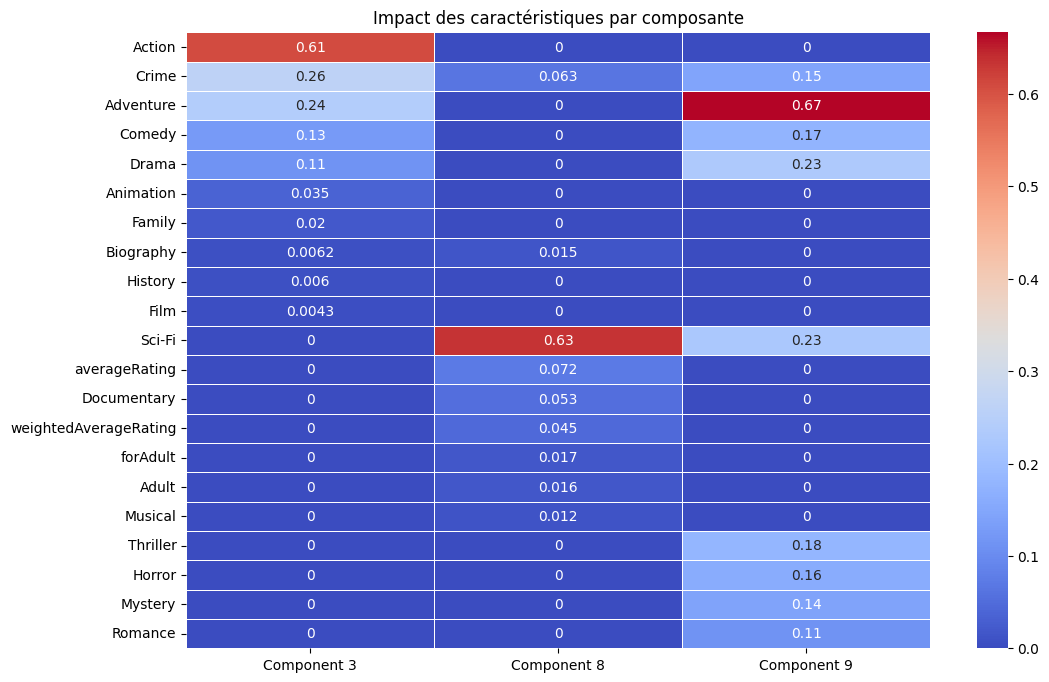

In [30]:
# Création du DataFrame pour la heatmap
data_heatmap = {
    'Component 3': {
        'Action': 0.607361,
        'Crime': 0.261891,
        'Adventure': 0.241960,
        'Comedy': 0.126450,
        'Drama': 0.112724,
        'Animation': 0.035027,
        'Family': 0.020394,
        'Biography': 0.006159,
        'History': 0.005971,
        'Film': 0.004314,
    },
    'Component 8': {
        'Sci-Fi': 0.633931,
        'averageRating': 0.071620,
        'Crime': 0.062820,
        'Documentary': 0.052827,
        'weightedAverageRating': 0.044627,
        'forAdult': 0.017178,
        'Adult': 0.016426,
        'Biography': 0.015496,
        'Musical': 0.012188,
    },
    'Component 9': {
        'Adventure': 0.666787,
        'Drama': 0.230796,
        'Sci-Fi': 0.226566,
        'Thriller': 0.182205,
        'Comedy': 0.174704,
        'Horror': 0.161104,
        'Crime': 0.145364,
        'Mystery': 0.141147,
        'Romance': 0.112254,
    }
}

# Conversion en DataFrame
df_heatmap = pd.DataFrame(data_heatmap)

# Remplissage des valeurs manquantes avec 0 (si une caractéristique n'existe pas pour une composante)
df_heatmap = df_heatmap.fillna(0)

# Création de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Impact des caractéristiques par composante')
plt.show()


<b>Interprétation de la Heatmap</b><br>

* Rouge foncé : Indique une forte influence positive de cette caractéristique sur la composante.

* Bleu : Indique une faible influence ou une influence négative.

* Blanc : Zéro ou pas d'influence

### Visualisation de l'espace réduit

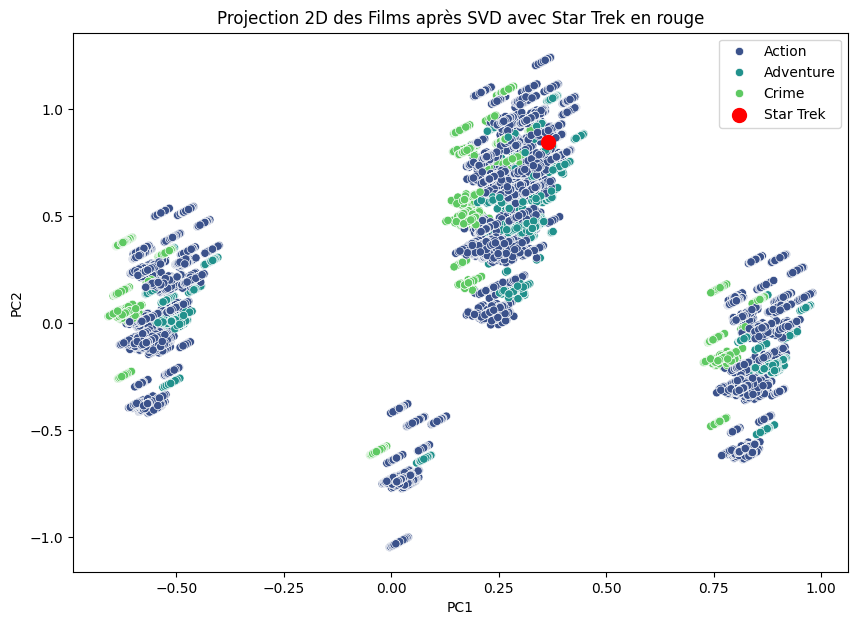

In [12]:
# Application de PCA pour réduire à 2 dimensions pour visualisation
pca = PCA(n_components=2)
films_pca = pca.fit_transform(reduced_features)

# Création d'un DataFrame pour la visualisation
df_pca = pd.DataFrame(films_pca, columns=['PC1', 'PC2'])
df_pca['title'] = df['title']
df_pca['genre'] = df[['Action', 'Adventure', 'Crime']].idxmax(axis=1)

# Visualisation de tous les films
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=df_pca, palette='viridis', legend='full')

# Mise en évidence de "Star Trek" avec un point rouge
star_trek = df_pca[df_pca['title'] == 'Star Trek']
plt.scatter(star_trek['PC1'], star_trek['PC2'], color='red', s=100, label='Star Trek')

# Ajout du titre et des légendes
plt.title('Projection 2D des Films après SVD avec Star Trek en rouge')
plt.legend()
plt.show()


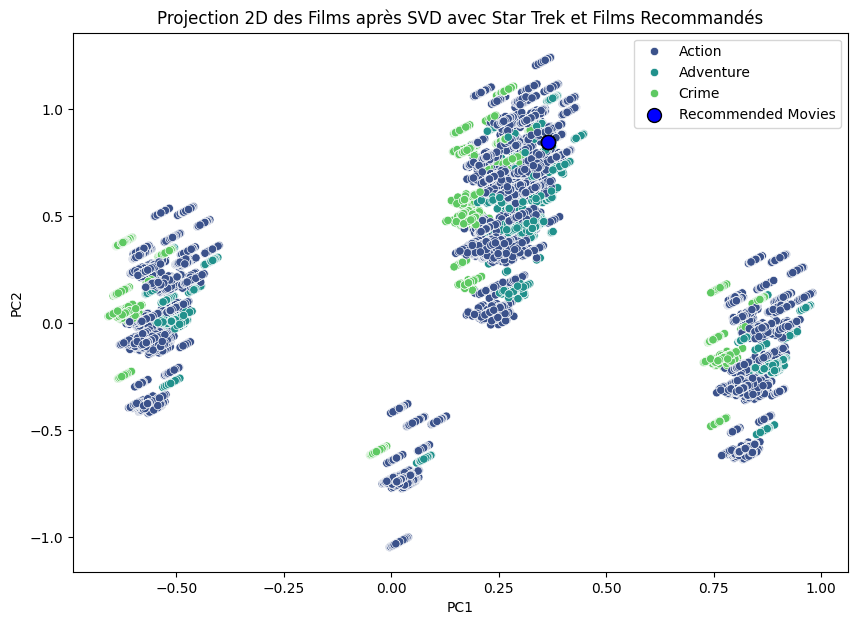

In [9]:
# Liste des films recommandés (indices des films obtenus via l'algorithme de recommandation)
recommended_titles = ['Edge of Tomorrow', 'X-Men: Days of Future Past', 'Rogue One: A Star Wars Story', 
                      'Star Wars: Episode VII - The Force Awakens', 'Star Trek Into Darkness']

# Visualisation de tous les films
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=df_pca, palette='viridis', legend='full')

# Mise en évidence des films recommandés avec une autre couleur (bleu)
recommended = df_pca[df_pca['title'].isin(recommended_titles)]
plt.scatter(recommended['PC1'], recommended['PC2'], color='blue', s=100, label='Recommended Movies', edgecolor='black')

# Ajout du titre et des légendes
plt.title('Projection 2D des Films après SVD avec Star Trek et Films Recommandés')
plt.legend()
plt.show()

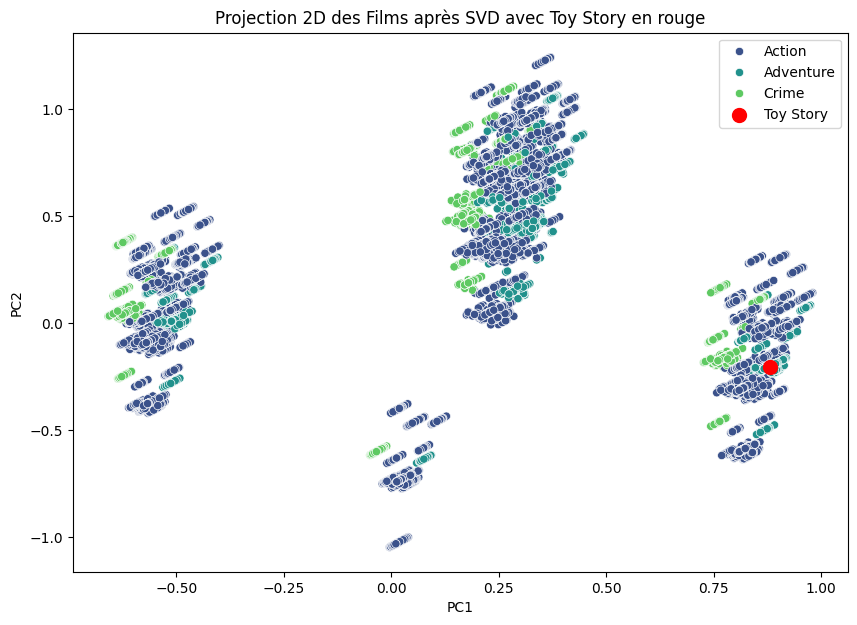

In [17]:
# Visualisation de tous les films
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=df_pca, palette='viridis', legend='full')

# Mise en évidence de "Star Trek" avec un point rouge
toy_story = df_pca[df_pca['title'] == 'Toy Story']
plt.scatter(toy_story['PC1'], toy_story['PC2'], color='red', s=100, label='Toy Story')

# Ajout du titre et des légendes
plt.title('Projection 2D des Films après SVD avec Toy Story en rouge')
plt.legend()
plt.show()

### Diagramme de calcul de la distance Euclidienne

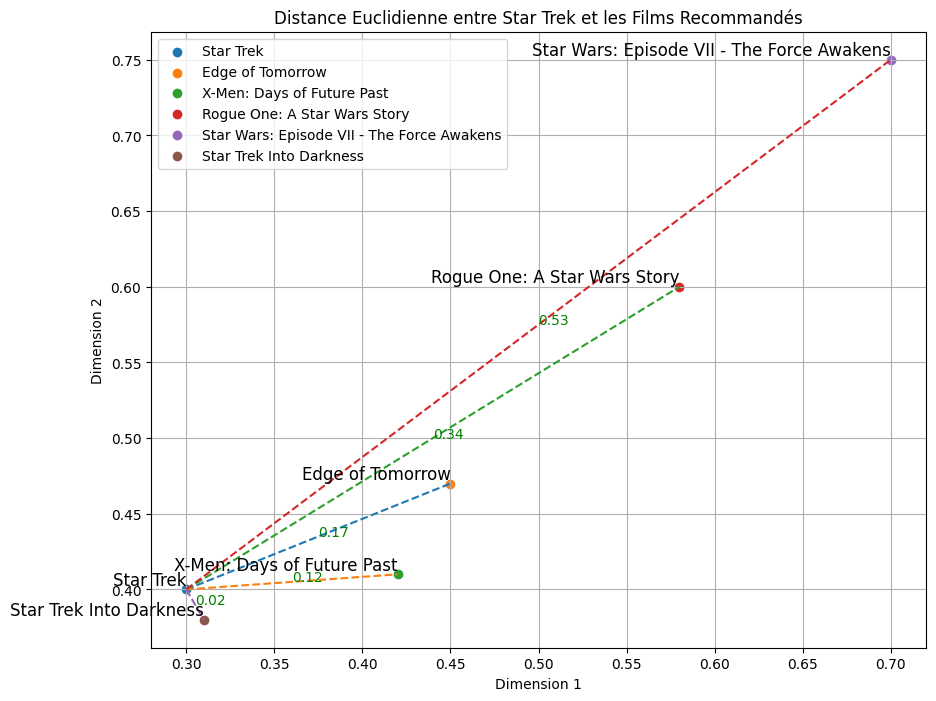

In [6]:
films = {
    'Star Trek': [0.3, 0.4],
    'Edge of Tomorrow': [0.45, 0.47],
    'X-Men: Days of Future Past': [0.42, 0.41],
    'Rogue One: A Star Wars Story': [0.58, 0.6],
    'Star Wars: Episode VII - The Force Awakens': [0.7, 0.75],
    'Star Trek Into Darkness': [0.31, 0.38]
}

# Extraction des noms et des vecteurs
titles = list(films.keys())
vectors = np.array(list(films.values()))

# Création du diagramme
plt.figure(figsize=(10, 8))

# Traçage des points représentant les films
for title, vector in films.items():
    plt.scatter(vector[0], vector[1], label=title)
    plt.text(vector[0], vector[1], title, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Traçage des lignes entre Star Trek et les films recommandés
star_trek_vector = films['Star Trek']
for title, vector in films.items():
    if title != 'Star Trek':
        distance = np.sqrt(np.sum((np.array(star_trek_vector) - np.array(vector)) ** 2))
        plt.plot([star_trek_vector[0], vector[0]], [star_trek_vector[1], vector[1]], linestyle='--')
        plt.text((star_trek_vector[0] + vector[0]) / 2, (star_trek_vector[1] + vector[1]) / 2,
                 f'{distance:.2f}', fontsize=10, color='green')

# Réglages du graphique
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Distance Euclidienne entre Star Trek et les Films Recommandés')
plt.legend()
plt.grid(True)
plt.show()